In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
## Get the details for Measurement class 

Measurement.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 282ab0bd3b8>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd4c0>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd570>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd5c8>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd620>,
              'tobs': <sqlalc

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastdatedt = dt.datetime.strptime(lastdate[0], '%Y-%m-%d')
query_date = lastdatedt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

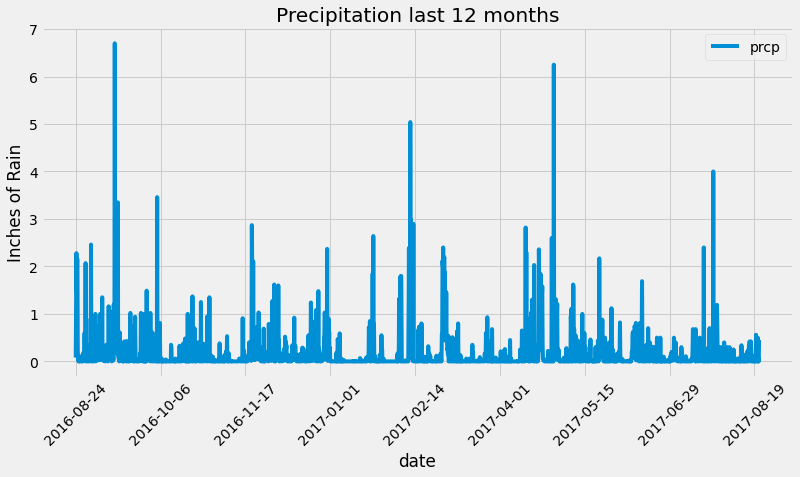

In [12]:

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.DataFrame(query_results).set_index('date').dropna()
# Sort the dataframe by date
query_df = query_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
query_df.plot(title='Precipitation last 12 months', figsize=(12,6), rot=45)
plt.ylabel('Inches of Rain')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
## Get the details for Measurement Station class

Station.__dict__

mappingproxy({'__table__': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 282ab0bd518>,
              '__init__': <function __init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd728>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd7d8>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd830>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x282ab0bd888

In [15]:
# Design a query to show how many stations are available in this dataset?

# Can check both classes - both queries below show 9 unique stations
session.query(Station.station).count()
# session.query(Measurement).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Station.station, Station.name, func.count(Measurement.id)).\
    group_by(Measurement.station).filter(Measurement.station == Station.station).\
        order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).first()
highest = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs.desc()).first()
average = session.query(func.avg(Measurement.tobs).filter(Measurement.station == 'USC00519281'))

print(f"{session.query(Station.name).filter(Station.station == 'USC00519281').all()[0][0]} \n" +
       "---------------------------- \n" +
       f"Lowest temperature: {lowest[0]} f \n" +
       f"Higest Temperature: {highest[0]} f \n" +
       f"Average Temperature: {round(average[0][0], 2)} f")

WAIHEE 837.5, HI US 
---------------------------- 
Lowest temperature: 54.0 f 
Higest Temperature: 85.0 f 
Average Temperature: 71.66 f


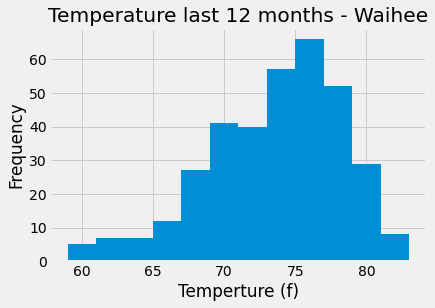

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
        filter(Measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(temp_results).set_index('date').dropna()
# Sort the dataframe by date
temp_df = temp_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot(kind='hist', title='Temperature last 12 months - Waihee', bins=12, legend='')
plt.xlabel('Temperture (f)')
plt.show()



## Bonus Challenge Assignment

## Temperature Analysis I



In [19]:
from sqlalchemy import extract  

jun_temp_avg = session.query(func.avg(Measurement.tobs)).\
    filter(extract('month', Measurement.date) == 6).all()

dec_temp_avg = session.query(func.avg(Measurement.tobs)).\
    filter(extract('month', Measurement.date) == 12).all()

print(f"Avg June Temp: {round(jun_temp_avg[0][0],2)} F")
print(f"Avg December Temp: {round(dec_temp_avg[0][0],2)} F")

Avg June Temp: 74.94 F
Avg December Temp: 71.04 F


In [20]:
import scipy.stats as stats

jun_temps = session.query(Measurement.tobs).\
    filter(extract('month', Measurement.date) == 6).all()

dec_temps = session.query(Measurement.tobs).\
    filter(extract('month', Measurement.date) == 12).all()

stats.ttest_ind(jun_temps, dec_temps, equal_var=False)


Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

A very small p value (<0.05) indicates the two sets of data did not happen by chance and there is statistical significance between June and December temperatures.  I used an independent test because the results occurred in two different months.

## Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = '2016-05-05'
prev_year_end = '2016-07-12'

tmin, tavg, tmax = calc_temps(prev_year_start, prev_year_end)[0]

print(f"Min: {tmin}   Avg: {tavg}  Max: {tmax}")

Min: 64.0   Avg: 75.09425287356322  Max: 82.0


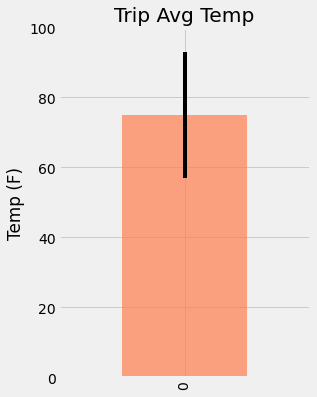

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

d = {"min":[tmin], "avg":[tavg], "max":[tmax]}
df_results = pd.DataFrame(d)
yerr = [df_results['max'] - df_results['min']]

df_results.plot(kind='bar', y='avg', yerr=yerr, color="coral",
                      alpha=0.7, figsize=(4,6), legend='', title='Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.ylim(0,100)
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,        func.sum(Measurement.prcp),).filter(Measurement.station == Station.station,
    Measurement.date.between('2016-05-05', '2016-07-12'),)\
    .group_by(Station.station)\
    .order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  28.649999999999995),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  16.98999999999999),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  11.290000000000001),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  7.85),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  5.490000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  1.5100000000000005),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 1.04)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2017-05-05'
end = '2017-07-12'
# Use the start and end date to create a range of dates
dates = pd.date_range(start=start, end=end)

# Stip off the year and save a list of %m-%d strings
strip_dates = [date.strftime('%m-%d') for date in dates]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date)[0] for date in strip_dates]
normals

[(67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0),
 (68.0, 74.4, 81.0),
 (64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.8181818181

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates_df = pd.DataFrame(dates, columns=['Date'])
trip_df = pd.DataFrame(normals, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
trip_df = pd.merge(dates_df, trip_df, left_index=True, right_index=True).set_index('Date')
trip_df.head()

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0


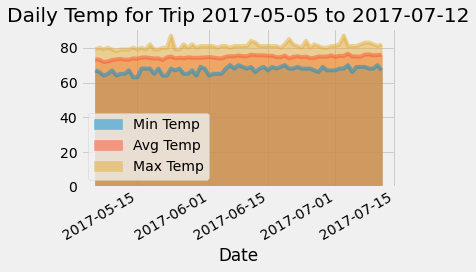

In [47]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, x_compat=True, title=f'Daily Temp for Trip {start} to {end}')
plt.tight_layout()
plt.show()